# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
ё- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
from nltk import bigrams, trigrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from scipy.sparse import csr_matrix



In [2]:
data = pd.read_csv('parsed_reviews3.csv', sep = ',', encoding='utf-8')
data['rating'] = data['rating'].astype(int)
data['date'] = pd.to_datetime(data['date'])
print(f'В исходном датафрейма {data.shape[0]} строк и {data.shape[1]} столбцов')
data.head(5)

В исходном датафрейма 92735 строк и 5 столбцов


,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36


### Часть 1 - EDA

Для начала поищем странности в исходных данных

In [3]:
# нет ни одного NaN - это хорошо
data.isnull().any()

body         False
title        False
rating       False
bank_name    False
date         False
dtype: bool

In [4]:
# с типами данных тоже все в порядке
data.dtypes

body                 object
title                object
rating                int32
bank_name            object
date         datetime64[ns]
dtype: object

In [5]:
# но есть дубликаты
data.duplicated().any()

True

In [6]:
# посмотрим на них
print(f'В датафрейме {data[data.duplicated()].shape[0]} дубликатов')
data[data.duplicated()].head(5)

В датафрейме 62 дубликатов


,body,title,rating,bank_name,date
899,&lt;p&gt;Обратился 3 декабря в районе 19 часов...,открытие счёта и получение банковской карты,5,Хоум Кредит Банк,2022-12-30 16:16:13
997,&lt;p&gt;С самого открытия являемся клиентами ...,"Сняли деньги за перевод физ.лицу, а услугу не ...",1,Норвик Банк,2022-12-30 14:06:33
1611,&lt;p&gt;22.12.2022 в чате своего ЛК мобильног...,Отсутствие информации о порядке конвертации ва...,2,Росбанк,2022-12-29 15:03:06
2502,"&lt;p&gt;Оформлял рассрочку на телефон, в мага...",Лучший кредитный банк,5,Хоум Кредит Банк,2022-12-28 13:44:16
2504,&lt;p&gt;28 декабря я посетил банк МКБ по адре...,Отличное обслуживание,5,Московский Кредитный Банк,2022-12-28 13:42:41


In [7]:
# удалим дубликаты
data = data.drop_duplicates()

На первый взгляд в датасете нет каких-то явно выраженных аномалий, так что можно перейти к ответам на поставленные вопросы:

1. Назвать топ-15 банков по числу отзывов

In [8]:
# топ-15 банков по числу отзывов
banks_reviews_and_rating = data.groupby(['bank_name']).agg({'body':'count', 'rating': 'mean'}).reset_index()
banks_reviews_and_rating.columns = ['bank_name', 'count', 'rating']
banks_reviews_and_rating['rating'] = banks_reviews_and_rating['rating'].round(2)
banks_reviews_and_rating.sort_values(by='count', ascending=False, inplace=True)
top15_banks_by_count = banks_reviews_and_rating.head(15).reset_index(drop=True)
top15_banks_by_count

,bank_name,count,rating
0,Тинькофф Банк,44852,4.78
1,Хоум Кредит Банк,9301,4.51
2,Совкомбанк,6100,4.26
3,ВТБ,3814,1.95
4,СберБанк,3487,2.30
5,Альфа-Банк,3368,1.71
6,Россельхозбанк,3062,4.46
7,Банк Открытие,1894,3.54
8,МТС Банк,1542,2.90
9,Модульбанк,1452,4.78


2. Назвать банк с самым высоким рейтингом из числа топ-15 банков по отзывам

In [9]:
top15_banks_by_count.sort_values(by='rating', ascending=False).head(1)

,bank_name,count,rating
0,Тинькофф Банк,44852,4.78


3. Сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов 

In [10]:
# сначала распарсим колонку date - пригодится для дальнейшего анализа
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute
data['second'] = data['date'].dt.second

Построим график изменения среднего рейтинга по месяцам у топ-5 банков по числу отзывов

In [11]:
data['year_month'] = data['year'].astype(str) + '-' + data['month'].astype(str)
data_to_graph = data[['bank_name','year_month','rating']]
data_to_graph = data_to_graph[data_to_graph['bank_name'].isin(top15_banks_by_count.head(5)['bank_name'])].groupby(['bank_name', 'year_month']).agg({'rating': 'mean'}).reset_index()
data_to_graph['rating'] = data_to_graph['rating'].round(2)
order = ['2022-9', '2022-10', '2022-11', '2022-12', '2023-1']
data_to_graph['year_month'] = pd.Categorical(data_to_graph['year_month'], categories=order, ordered=True)
data_to_graph = data_to_graph.sort_values(by=['bank_name', 'year_month']).reset_index(drop=True)
data_to_graph

,bank_name,year_month,rating
0,ВТБ,2022-9,2.07
1,ВТБ,2022-10,1.91
2,ВТБ,2022-11,1.99
3,ВТБ,2022-12,1.90
4,ВТБ,2023-1,1.15
5,СберБанк,2022-9,1.92
6,СберБанк,2022-10,2.78
7,СберБанк,2022-11,2.56
8,СберБанк,2022-12,1.87
9,СберБанк,2023-1,1.40


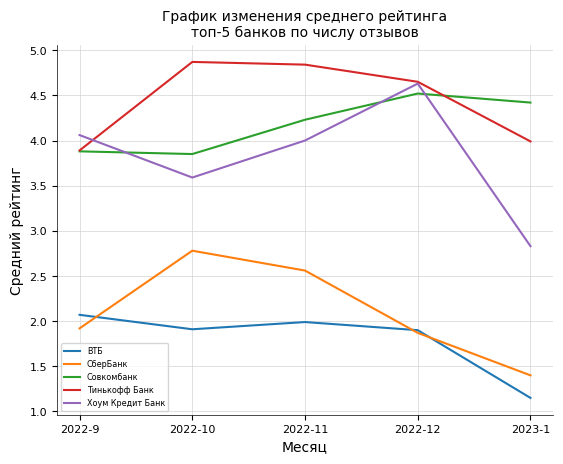

In [12]:
# data_to_graph['month'] = data_to_graph['month'].astype(str)
banks = data_to_graph['bank_name'].unique()

# plt.figure(figsize=(8, 5))
for b in banks:
    bank_data = data_to_graph[data_to_graph['bank_name'] == b]
    plt.plot(bank_data['year_month'], bank_data['rating'], label=b)
plt.title('График изменения среднего рейтинга\nтоп-5 банков по числу отзывов', fontsize=10)
plt.xlabel('Месяц')
plt.ylabel('Средний рейтинг')
plt.box(True)
plt.legend(fontsize='xx-small', loc='lower left')
plt.grid(True, linestyle='-', linewidth=0.5, color='lightgrey')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
plt.show()


##### Выводы

- У Тинькофф банка самый высокий средний рейтинг во все месяцы, кроме декабря, в декабре его обгоняет Совкомбанк.
- У 4 из 5 банков средний рейтинг падает со временем. Исключение - Совкомбанк, чей рейтинг с каждым месяцем только растет.
- После октября рейтинг Тинькофф банка и Сбербанка по какой-то причине начинает падать. Очень интересно узнать, в чем причина (спойлер - узнаем)
- Рейтинг Хоум Кредит Банка очень сильно упал в январе, хотя до этого он испытал довольно стремительный рост


4. Нет ли в данных в целом каких-то странностей на ваш взгляд?

Самая большая странность, на мой взгляд, это то, что отзывов на Тинькофф банк в разы больше, чем отзывов на другие банки.
Причин этому может быть несколько. Это мог быть баг на этапе сбора данных, или, может быть, клиенты Тинькофф банка в целом чаще оставляют отзывы в интернете (все таки, Тинькофф - это мобильный банк, и его пользователи в принципе пользуются интернетом чаще, чем клиенты других банков, но это скорее мое личное мнение)

Так или иначе, дизбаланс есть, и это бесит, особенно когда доходит до текстового анализа, чуть позже покажу, почему.

5. Дополнительный EDA

Сейчас я хочу проанализироать временные данные.

Посмотрим, в какое время пишут отрицательные отзывы, а в какое - положительные

Я буду считать положительными отзывы >= 3, а отрицательными - <3, как сказано в задании

In [13]:
# сразу добавлю колонку "class": 0 - отзыв отрицательный, 1 - положительный. Это пригодится сейчас и на этапе с метрикой
data['class'] = data['rating'].apply(lambda x: 1 if x >= 3 else 0)

In [14]:
# делаю группировку по часу и рейтингу и считаю средний рейтинг
pos_and_neg_hour = data.groupby(['hour', 'class']).size().reset_index(name='count')
count_rating_pos = data[data['class'] == 1].shape[0]
count_rating_neg = data[data['class'] == 0].shape[0]
pos_and_neg_hour['percentage'] = pos_and_neg_hour.apply(lambda row: row[2]/count_rating_pos * 100 if row[1] == 1 else row[2]/count_rating_neg * 100, axis=1).round(2)
pos_and_neg_hour.head(6)

C:\Users\mayko\AppData\Local\Temp\ipykernel_19292\1257091007.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pos_and_neg_hour['percentage'] = pos_and_neg_hour.apply(lambda row: row[2]/count_rating_pos * 100 if row[1] == 1 else row[2]/count_rating_neg * 100, axis=1).round(2)


,hour,class,count,percentage
0,0,0,459,2.20
1,0,1,1664,2.32
2,1,0,277,1.33
3,1,1,1108,1.54
4,2,0,181,0.87
5,2,1,764,1.06


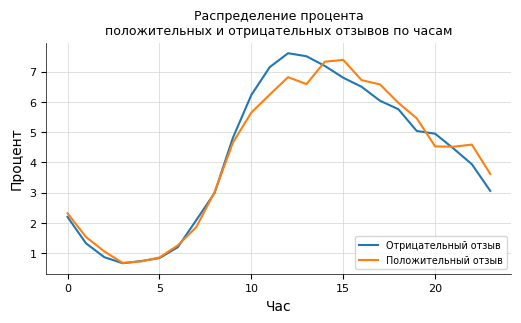

In [20]:
fig, ax = plt.subplots(figsize=(6, 3))
for c in [0, 1]:
    rating_data = pos_and_neg_hour[pos_and_neg_hour['class'] == c]
    ax.plot(rating_data['hour'], rating_data['percentage'], label='Положительный отзыв' if c == 1 else 'Отрицательный отзыв')

ax.set_xlabel('Час')
ax.set_ylabel('Процент')
ax.set_title('Распределение процента\nположительных и отрицательных отзывов по часам', fontsize=9)
ax.legend(fontsize='x-small', loc='lower right')
plt.grid(True, linestyle='-', linewidth=0.5, color='lightgrey')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
plt.show()


В целом, нет большой разницей между тем, в какое время люди пишут отзыв. Можно увидеть, что самое большое количество положительных отзывов пишут в районе 15 часов, а самое большое количество отрицательных отзывов пользователи оставляют около полудня.

**А сейчас минутка NLP**

Перед тем, как перейти к части с предсказанием оценки, я бы хотела провести небольшой анализ текста и посмотреть, что пишут люди, когда им нравится банк, и когда он им не нравится

In [21]:
import nltk
from nltk.corpus import stopwords
ru_stopwords = stopwords.words("russian")
from nltk.tokenize import sent_tokenize, word_tokenize
import pymorphy3
from nltk.stem import SnowballStemmer
import time
from sklearn.feature_extraction.text import TfidfVectorizer


Сначала очистим текст, сделаем токенизацию и лемматизацию

In [22]:
from bs4 import BeautifulSoup
import re
def preprocess(data):
    cleaned_body = []
    morph = pymorphy3.MorphAnalyzer()
    d = list(data['body'])
    for b in d:
        soup = BeautifulSoup(b, 'html.parser')
        text = soup.get_text()
        text = BeautifulSoup(text)
        b = text.get_text()
        words = re.findall(r'\b[а-яА-Яa-zA-Z]+\b', b)
        processed_words = []
        for w in words:
            if w.isalpha() and len(w) > 1 and w not in ru_stopwords:
                w = w.strip()
                try:
                    w = morph.parse(w)[0].normal_form
                    processed_words.append(w)
                except:
                    processed_words.append(w)

        cleaned_body.append(' '.join(processed_words))
    data['cleaned_body'] = cleaned_body
    return data

In [23]:
nlp_cols = 'body cleaned_body title bank_name rating date class'.split()
nlp_data = preprocess(data)[nlp_cols]
# nlp_data['title'] = nlp_data['title'].lower( )
# nlp_data = nlp_data[nlp_cols]
nlp_data.head()

C:\Users\mayko\AppData\Local\Temp\ipykernel_19292\292819202.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(b, 'html.parser')


,body,cleaned_body,title,bank_name,rating,date,class
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,добрый день писать сюда скорый разрешение вопр...,Заблокировали средства,Еком Банк,1,2023-01-03 12:46:11,0
1,&lt;p&gt;При возврате просроченной задолженнос...,при возврат просрочить задолженность банк звон...,Возврат просроченной задолженномти,Тинькофф Банк,1,2023-01-03 12:31:46,0
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,оформить кредитный карта день банк открытие по...,"Ошибочное начисление комиссии, затягивание про...",Банк Открытие,1,2023-01-03 12:23:11,0
3,&lt;p&gt;Новый год начинается с приятностей)&l...,новый год начинаться приятность никогда понима...,Клиентоориентиванность 10 из 10,Тинькофф Банк,5,2023-01-03 12:16:07,1
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,увидеть сайт газпромбанк акция бонус кредитный...,Как Газпромбанк обманывает клиентов с акционны...,Газпромбанк,1,2023-01-03 12:12:36,0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import numpy as np

# Предположим, у вас есть большой корпус текстов
corpus = list(nlp_data['cleaned_body'])
# Инициализация TfidfVectorizer с использованием частичного обучения
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)

# Разделение корпуса на порции и частичное обучение
batch_size = 1000
num_batches = int(np.ceil(len(corpus) / batch_size))

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(corpus))
    batch = corpus[start_idx:end_idx]
    tfidf_vectorizer.partial_fit(batch)

# Сохранение обученного векторайзера
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Загрузка обученного векторайзера
loaded_tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

tfidf_matrix_new = loaded_tfidf_vectorizer.transform(corpus)


NameError: name 'nlp_data' is not defined

In [ ]:
tf_idf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
documents = data['cleaned_body'].tolist()
tfidf_matrix = tf_idf_vectorizer.fit_transform(documents)
feature_names = tf_idf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()

In [36]:
for i in tfidf_scores:
    print(sorted(enumerate(i)))

68503

In [ ]:
nlp_data_pos = nlp_data[nlp_data['class'] == 1]
nlp_data_neg = nlp_data[nlp_data['class'] == 0]

In [ ]:
def get_bigr_and_trigr(nlp_data):
    bigrams_list = []
    trigrams_list = []

    for r in nlp_data['cleaned_body']:
        r = r.split()
        b = list(bigrams(r))
        t = list(trigrams(r))
        bigrams_list += b
        trigrams_list += t
    bigr_freq = Counter(bigrams_list)
    trigr_freq = Counter(trigrams_list)
    rows1 = [[' '.join(x[0]), x[1]] for x in bigr_freq.most_common(15)]
    bigr_freq = pd.DataFrame(rows1, columns=['bigr', 'n'])
    rows2 = [[' '.join(x[0]), x[1]] for x in trigr_freq.most_common(15)]
    trigr_freq = pd.DataFrame(rows2, columns=['bigr', 'n'])
    return bigr_freq, trigr_freq

In [ ]:
rating1_bigr, rating1_trigr = get_bigr_and_trigr(nlp_data_pos)
pd.merge(rating1_bigr, rating1_trigr, how="outer")

,bigr,n
0,дебетовый карта,12365
1,тинькофф банк,10739
2,кредитный карта,8234
3,другой банк,7809
4,карта тинькофф,6849
5,мобильный приложение,6014
6,хороший банк,5981
7,банк тинькофф,5587
8,сотрудник банк,5174
9,очень удобный,4655


Теперь посчитаем tf-idf для каждого слова в отзыве и оставим только самые выажные слова - чтобы избавиться от слов типо "доброе утро"

In [ ]:
def top_tfidf_words(row, n=20):
    return row.sort_values(ascending=False).index[:n].tolist()
top_words_rating1 = tfidf_rating1.apply(top_tfidf_words, axis=1)

In [ ]:
rating1_bigr, rating1_trigr = get_bigr_and_trigr(nlp_data_rating1)


In [ ]:
rating1_bigr

,bigr,n
0,кредитный карта,3863
1,горячий линия,3686
2,сотрудник банк,3006
3,денежный средство,2927
4,альфа банк,2618
5,дебетовый карта,2191
6,отделение банк,2087
7,личный кабинет,1761
8,добрый день,1719
9,мобильный приложение,1465


In [ ]:
rating1_trigr

,bigr,n
0,позвонить горячий линия,710
1,звонить горячий линия,495
2,на следующий день,386
3,являться клиент банк,371
4,оформить кредитный карта,308
5,горячий линия банк,308
6,обратиться отделение банк,301
7,на горячий линия,271
8,карта другой банк,271
9,льготный период день,257


In [ ]:
def draw_net(data_for_net, edge_color = '#71a5e3', node_color = '#1e589e'):
    G = nx.Graph()
    for _, row in data_for_net.iterrows():
        words = row['bigr'].split()
        connections = [(words[i], words[i+1]) for i in range(len(words)-1)]
        G.add_edges_from(connections)

    layout = nx.spring_layout(G)
    edge_1 = []
    edge_2 = []

    for edge in G.edges():
        x0, y0 = layout[edge[0]]
        x1, y1 = layout[edge[1]]
        edge_1.append(x0)
        edge_1.append(x1)
        edge_1.append(None)
        edge_2.append(y0)
        edge_2.append(y1)
        edge_2.append(None)

    edges = go.Scatter(
        x=edge_1, y=edge_2,
        line=dict(width=0.5, color=edge_color),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    node_labels = []
    for node in G.nodes():
        x, y = layout[node]
        node_x.append(x)
        node_y.append(y)
        node_labels.append(node)

    nodes = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        text=node_labels,
        textposition='bottom center',
        marker={"color":node_color, "size":10}
    )

    fig = go.Figure(data=[edges, nodes],
                layout=go.Layout(
                    width=800,
                    height=600,
                    showlegend=False,
                    hovermode='closest',
                    margin = {'b': 0, 'l': 0, 'r': 0, 't': 0},
                    xaxis = {'showgrid': False, 'zeroline': False, 'showticklabels': False},
                    yaxis = {'showgrid': False, 'zeroline': False, 'showticklabels': False}))

    fig.show()


In [ ]:
data_for_net = pd.merge(rating1_bigr, rating1_trigr, how="outer")
draw_net(data_for_net)

In [ ]:
rating5_bigr, rating5_trigr = get_bigr_and_trigr(nlp_data_rating5)

In [ ]:
rating5_bigr

,bigr,n
0,дебетовый карта,11569
1,тинькофф банк,10515
2,другой банк,7195
3,кредитный карта,7177
4,карта тинькофф,6641
5,хороший банк,5776
6,мобильный приложение,5476
7,банк тинькофф,5448
8,сотрудник банк,4879
9,очень удобный,4513


In [ ]:
rating5_trigr

,bigr,n
0,дебетовый карта тинькофф,2344
1,хотеть выразить благодарность,1868
2,пользоваться услуга банк,1321
3,пользоваться дебетовый карта,1279
4,карта tinkoff black,1275
5,являться клиент банк,1223
6,банк хоум кредит,1165
7,самый хороший банк,1128
8,карта тинькофф банк,1024
9,добрый день хотеть,965


In [ ]:
draw_net(pd.merge(rating5_bigr, rating5_trigr, how="outer"), edge_color="#cf9db4", node_color="#915f6d")